# Clean With IR

## 1. Make the mesh

In [80]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import gmsh
from dolfinx import fem
import pandas as pd
import numpy as np

from mesh_and_materials.mesh import *
from mesh_and_materials.materials import *
from space.space_and_forms import *
from dirichlet_bc.bc import *

In [82]:

# Sample geometry (all units in meters)

d_ins_oside = 6.3e-6
d_ins_pside = 3.2e-6
d_sample    = 1.84e-6
d_ir        = 0.062e-6

# Mesh bounds
x_length = d_ins_oside + d_ins_pside + d_sample + 2 * d_ir
mesh_xmin, mesh_xmax = -(x_length/2), x_length/2
mesh_ymin, mesh_ymax = -20e-6, 0

# Heating params
heating_FWHM = 13.2e-6


In [83]:

# Material regions (from left to right)
bx_ins_pside = mesh_xmin
BX_ins_pside = mesh_xmin + d_ins_pside

bx_ir_pside  = BX_ins_pside
BX_ir_pside  = bx_ir_pside + d_ir

bx_sample = BX_ir_pside
BX_sample = bx_sample + d_sample

bx_ir_oside = BX_sample
BX_ir_oside = bx_ir_oside + d_ir

bx_ins_oside = BX_ir_oside
BX_ins_oside = bx_ins_oside + d_ins_oside

ins_pside = Material(
    "pside ins",
    [bx_ins_pside, BX_ins_pside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

ir_pside = Material(
    "pside ir",
    boundaries=[bx_ir_pside, BX_ir_pside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 26504 * 130, "k": 352},
    mesh_size=0.02e-6
)

sample = Material(
    "sample",
    boundaries=[bx_sample, BX_sample, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 5164 * 1158, "k": 3.9},
    mesh_size=0.08e-6
)

ir_oside = Material(
    "oside ir",
    boundaries=[bx_ir_oside, BX_ir_oside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 26504 * 130, "k": 352},
    mesh_size=0.02e-6
)

ins_oside = Material(
    "oside ins",
    boundaries=[bx_ins_oside, BX_ins_oside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

materials = [ins_pside, ir_pside, sample, ir_oside, ins_oside]

gmsh_domain = Mesh(
    name="clean",
    boundaries=[mesh_xmin, mesh_xmax, mesh_ymin, mesh_ymax],
    materials=materials
)


In [84]:
gmsh_domain.build_mesh()

no mesh errors found
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 13 (Line)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [100%] Meshing curve 19 (Line)
Info    : Done meshing 1D (Wall 0.00377705s, CPU 0.005869s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 4 (Plan

In [85]:
gmsh_domain.write('clean_with_ir.msh')
# Visualize in gmsh if desired
gmsh.open('clean_with_ir.msh')
gmsh.fltk.initialize()
gmsh.fltk.run()

Info    : Writing 'clean_with_ir.msh'...
Info    : Done writing 'clean_with_ir.msh'
Info    : Reading 'clean_with_ir.msh'...
Info    : 33 entities
Info    : 205776 nodes
Info    : 410885 elements                                                                                     
Info    : Done reading 'clean_with_ir.msh'                                                                       
-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240524
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[

In [86]:
gmsh.finalize()

## 2. Run the simulation

In [87]:

# Experimental heating curve

df = pd.read_csv('experimental_data/geballe_2020_fig3_left_approx.csv')
df = df.copy().iloc[1:].reset_index(drop=True)

# split front/back columns and clean
df_pside = df[['Front', 'Unnamed: 1']].copy()
df_oside = df[['Back',  'Unnamed: 3']].copy()

df_pside.columns = ['time', 'temperature']
df_oside.columns = ['time', 'temperature']

df_pside = (df_pside
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_oside = (df_oside
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_pside['time'] = df_pside['time'] * 10**-6
df_oside['time'] = df_oside['time'] * 10**-6

df_pside['normed temperature'] = (
    df_pside['temperature'] - df_pside['temperature'].iloc[0]
) / (df_pside['temperature'].max() - df_pside['temperature'].min())

df_oside['normed temperature'] = (
    df_oside['temperature'] - df_oside['temperature'].iloc[0]
) / (df_pside['temperature'].max() - df_pside['temperature'].min())


In [88]:
import os
rebuild_mesh = False
mesh_file = 'clean_with_ir.msh'
if not os.path.exists(mesh_file) or rebuild_mesh:
    gmsh_domain.build_mesh()
    gmsh_domain.write(mesh_file)

dolfinx_domain = Mesh.msh_to_dolfinx(mesh_file) # (mesh, cell_tags, facet_tags)


Info    : Reading 'clean_with_ir.msh'...
Info    : 33 entities
Info    : 205776 nodes
Info    : 410885 elements                                                                                     
Info    : Done reading 'clean_with_ir.msh'                                                                       


In [89]:

spaces = Space(dolfinx_domain, V_family='Lagrange', V_degree=1, Q_family='DG', Q_degree=0)

rho_cv_fxn = spaces.assign_material_property(materials, 'rho_cv')
k_fxn = spaces.assign_material_property(materials, 'k')


In [90]:
spaces.cell_map = gmsh_domain.material_tags

In [91]:

ic_temp = 300.0
ic_fxn = spaces.initial_condition(ic_temp)
u_n = fem.Function(spaces.V)
u_n.x.array[:] = ic_fxn.x.array
u_n.x.scatter_forward()


In [92]:

from scipy.interpolate import make_interp_spline

pside_heating_spline_interp = make_interp_spline(df_pside['time'], df_pside['temperature'], k=3)
offset = df_pside['temperature'].iloc[0] - 300

def heating_offset(t):
    return float(pside_heating_spline_interp(t))

# Gaussian profile for inner boundary
heating_FWHM = 13.2e-6
coeff = -4.0 * np.log(2.0) / heating_FWHM**2
y_center = 0.0

def gaussian_pside(x, y, t):
    amp = heating_offset(t) - ic_temp
    return (amp) * np.exp(coeff * (y - y_center)**2) + ic_temp

def gaussian_oside(x, y, t):
    amp = df_oside['temperature'].iloc[0] - ic_temp
    return (amp) * np.exp(coeff * (y - y_center)**2) + ic_temp

bcs = []
left_bc = RowDirichletBC(spaces.V, 'left', value=ic_temp)
right_bc = RowDirichletBC(spaces.V, 'right', value=ic_temp)
bottom_bc = RowDirichletBC(spaces.V, 'bottom', value=ic_temp)
top_bc = RowDirichletBC(spaces.V, 'top', value=ic_temp)
trans_pside_bc = RowDirichletBC(
    spaces.V,
    'x',
    coord=bx_ir_pside,
    length=heating_FWHM * 2,
    center=0.0,
    value=gaussian_pside,
)


steady_pside_bc = RowDirichletBC(spaces.V, 'x', 
                                 coord = bx_ir_pside, 
                                 length=heating_FWHM, 
                                 center = 0.0, 
                                 value = df_pside['temperature'].iloc[0])
steady_oside_bc = RowDirichletBC(spaces.V, 'x', 
                                 coord=BX_ir_oside, 
                                 length=heating_FWHM, 
                                 center=0.0, 
                                 value= df_oside['temperature'].iloc[0])

steady_obj_bcs = [steady_pside_bc, steady_oside_bc, left_bc, right_bc, bottom_bc]
steady_dolfinx_bcs = [x.bc for x in steady_obj_bcs]

outer_obj_bcs = [left_bc, right_bc, bottom_bc]
outer_dolfinx_bcs = [x.bc for x in outer_obj_bcs]

In [93]:
RowDirichletBC.describe_row_bcs(steady_obj_bcs)

Row BC #0: x in [-2.532e-06, -2.532e-06]  y in [-6.600e-06, 2.642e-25]  (n = 331 DOFs)
Row BC #1: x in [-5.680e-07, -5.680e-07]  y in [-6.600e-06, 1.110e-24]  (n = 331 DOFs)
Row BC #2: x in [-5.732e-06, -5.732e-06]  y in [-2.000e-05, 1.583e-24]  (n = 201 DOFs)
Row BC #3: x in [5.732e-06, 5.732e-06]  y in [-2.000e-05, -9.525e-24]  (n = 201 DOFs)
Row BC #4: x in [-5.732e-06, 5.732e-06]  y in [-2.000e-05, -2.000e-05]  (n = 135 DOFs)


# Steady state solve

In [ ]:
# Solve in steady state -------------------------------------------------------

from dolfinx.fem.petsc import assemble_matrix


spaces.build_steady_state_variational_forms(k_fxn)

A = assemble_matrix(spaces.a_form_steady, bcs=steady_dolfinx_bcs)
A.assemble()
b = fem.petsc.create_vector(spaces.L_form_steady)

solver = PETSc.KSP().create(A.getComm())
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

from io_utilities.xdmf_utils import *

# set up output folder for steady-state
outputs_folder = os.path.join(os.getcwd(), 'sim_outputs')
save_folder = os.path.join(outputs_folder, 'steady_state_soln')
os.makedirs(save_folder, exist_ok=True)

# initialize XDMF for steady state
xdmf_ss = init_xdmf(spaces.mesh, save_folder, 'steady_state_solution')

u_ss = fem.Function(spaces.V)
u_ss.name = 'Steady State Temperature (K)'

with b.localForm() as local_b:
    local_b.set(0)

for x in steady_obj_bcs:
    x.update(0.0)

fem.petsc.assemble_vector(b, spaces.L_form_steady)
fem.petsc.apply_lifting(b, [spaces.a_form_steady], [steady_dolfinx_bcs])
b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
fem.petsc.set_bc(b, steady_dolfinx_bcs)

solver = PETSc.KSP().create(A.getComm())
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

solver.solve(b, u_ss.x.petsc_vec)

xdmf_ss.write_function(u_ss, 0.0)
xdmf_ss.close()

In [118]:
# Build b_equiv -------------------------------------------------------

from petsc4py import PETSc
from dolfinx.fem.petsc import assemble_matrix, apply_lifting

o_outer = [left_bc, right_bc, bottom_bc]
outer_dolfinx_bcs = [bc.bc for bc in o_outer]

# 1) Assemble full operator WITHOUT BCs
# a_form_steady: bilinear form for steady-state problem
A_free = assemble_matrix(spaces.a_form_steady, bcs=[])
A_free.assemble()

# 2) Build divergence-only load
b_equiv = A_free.createVecRight()
A_free.mult(u_ss.x.petsc_vec, b_equiv)

# 3) Zero out outer Dirichlet DOFs in b_equiv
outer_dirichlet_dofs = [bc.row_dofs for bc in outer_obj_bcs]  # get actual DOF indices from your BC objects
flat_dofs = np.concatenate(outer_dirichlet_dofs)
b_eq_no_outer = b_equiv.copy()
b_eq_no_outer.setValues(flat_dofs, [0]*len(flat_dofs))
b_eq_no_outer.assemblyBegin(); b_eq_no_outer.assemblyEnd()

# 4) Zero out p-side Dirichlet DOFs in addition to outer DOFs
pside_dirichlet_dofs = steady_pside_bc.row_dofs
b_eq_no_p = b_eq_no_outer.copy()
b_eq_no_p.setValues(pside_dirichlet_dofs, [0]*len(pside_dirichlet_dofs))
b_eq_no_p.assemblyBegin(); b_eq_no_p.assemblyEnd()

b_equiv is the heat flow from the pure divergence field.

In [132]:
# Apply outer dirichlet BCs to b_equiv and check in matrix form if it reproduces the steady state solution

# 4) Enforce BCs on A_free → A_bc
A_bc = assemble_matrix(spaces.a_form_steady, bcs=outer_dolfinx_bcs)
A_bc.assemble()

# 5) Prepare solver
solver = PETSc.KSP().create(A_bc.getComm())
solver.setOperators(A_bc)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

# 6) Build RHS: apply lifting + set BCs on b_equiv copy
b = b_eq_no_outer.copy()
apply_lifting(b, [spaces.a_form_steady], [outer_dolfinx_bcs])
b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
fem.petsc.set_bc(b, outer_dolfinx_bcs)

# 7) Solve and compare
u_chk = u_ss.copy()
solver.solve(b, u_chk.x.petsc_vec)
u_chk.x.scatter_forward()
err = np.max(np.abs(u_chk.x.array - u_ss.x.array))
print(f"Reproduction error = {err:e}")  # should be ~machine precision

Reproduction error = 1.041826e-08


This confirms that the system A_bc * u_chk = b_equiv solves to u_ss (within machine precision). A_bc is the matrix containing only the outer dirichlet BCs. b_equiv must have the entires corresponding to the outer dirichlet dofs zeroed, since apply_lifitng *adds* the BC contributions to b_bc, without zeroing b_bc first.

In [ ]:
# Checking steady state in transient solver ---------------------------------
# This step is not strictly necessary, but it is useful to ensure that the steady 
# state solution is correctly reproduced in the transient solver.

try:
    xdmf.close()
except:
    None

time_stop = 7.0e-6
num_steps = 200
dt = time_stop/num_steps

# 1) Start from steady state solution, build variational forms
u_n = u_ss.copy()  # Start from steady state solution
a_form, L_form = spaces.build_variational_forms(rho_cv_fxn, k_fxn, u_n, dt) 
u_n.name = 'Temperature (K)'

# init output -------------------------------------------------------------
outputs_folder = os.path.join(os.getcwd(), 'sim_outputs')
save_folder = os.path.join(outputs_folder, 'trans_steady_test')
os.makedirs(save_folder, exist_ok=True)

xdmf = init_xdmf(spaces.mesh, save_folder, 'solution')
xdmf.write_function(u_n, 0.0)
# -------------------------------------------------------------------------

# 2) Assemble full operator with outer Dirichlet BCs
A_bc = assemble_matrix(a_form, bcs=outer_dolfinx_bcs)
A_bc.assemble()

# 3) Scale b_equiv to the timestep dt
b_eq_no_outer_c = b_eq_no_outer.copy() # make a copy of b_equiv without outer Dirichlet BCs to ensure we don't overwrite the original b_equiv
b_eq_no_outer_c.scale(dt) 

# 4) prepare solver
solver = PETSc.KSP().create(A_bc.getComm())
solver.setOperators(A_bc)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

# initially update outer bcs
for x in outer_obj_bcs:
    x.update(0.0)

action_fmt = "{:<4d}/{:<4d}   ‖drift‖∞ = {:9.3e}"
# 5) Run transient loop
for step in range(num_steps):
    t = (step+1) * dt 
    for x in

    # 1) Assemble RHS vector from L_form
    b = fem.petsc.assemble_vector(L_form)

    fem.petsc.apply_lifting(b, [a_form], [outer_dolfinx_bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, outer_dolfinx_bcs)

    # 2) Add equivalent load from steady state solution
    b.axpy(1.0, b_eq_no_outer_c)

    # 3) Solve
    solver.solve(b, u_n.x.petsc_vec)
    u_n.x.scatter_forward()

    # 4) Monitor drift from steady state
    drift_inf = np.max(np.abs(u_n.x.array - u_ss.x.array))
    print(action_fmt.format(step, num_steps, drift_inf))

    # 5) Write output
    xdmf.write_function(u_n, t)

xdmf.close()


0   /200    ‖drift‖∞ = 1.656e-09
1   /200    ‖drift‖∞ = 2.205e-09
2   /200    ‖drift‖∞ = 2.574e-09
3   /200    ‖drift‖∞ = 2.869e-09
4   /200    ‖drift‖∞ = 3.118e-09
5   /200    ‖drift‖∞ = 3.337e-09
6   /200    ‖drift‖∞ = 3.538e-09
7   /200    ‖drift‖∞ = 3.718e-09
8   /200    ‖drift‖∞ = 3.889e-09
9   /200    ‖drift‖∞ = 4.047e-09
10  /200    ‖drift‖∞ = 4.199e-09
11  /200    ‖drift‖∞ = 4.340e-09
12  /200    ‖drift‖∞ = 4.478e-09
13  /200    ‖drift‖∞ = 4.611e-09
14  /200    ‖drift‖∞ = 4.736e-09
15  /200    ‖drift‖∞ = 4.861e-09
16  /200    ‖drift‖∞ = 4.980e-09
17  /200    ‖drift‖∞ = 5.096e-09
18  /200    ‖drift‖∞ = 5.208e-09
19  /200    ‖drift‖∞ = 5.317e-09
20  /200    ‖drift‖∞ = 5.424e-09
21  /200    ‖drift‖∞ = 5.531e-09
22  /200    ‖drift‖∞ = 5.633e-09
23  /200    ‖drift‖∞ = 5.732e-09
24  /200    ‖drift‖∞ = 5.828e-09
25  /200    ‖drift‖∞ = 5.926e-09
26  /200    ‖drift‖∞ = 6.021e-09
27  /200    ‖drift‖∞ = 6.115e-09
28  /200    ‖drift‖∞ = 6.205e-09
29  /200    ‖drift‖∞ = 6.294e-09
30  /200  

In [159]:
# Running transient simulation with pulsed heating ---------------------------------

try:
    xdmf.close()
except:
    None

pulsed_obj_bcs = [left_bc, right_bc, bottom_bc, trans_pside_bc]
pulsed_dolfinx_bcs = [x.bc for x in pulsed_obj_bcs]

time_stop = 7.0e-6
num_steps = 200
dt = time_stop/num_steps

# 1) Start from steady state solution, build variational forms
u_n = u_ss.copy()  # Start from steady state solution
a_form, L_form = spaces.build_variational_forms(rho_cv_fxn, k_fxn, u_n, dt) 
u_n.name = 'Temperature (K)'

# init output -------------------------------------------------------------
outputs_folder = os.path.join(os.getcwd(), 'sim_outputs')
save_folder = os.path.join(outputs_folder, 'trans_pulsed_test')
os.makedirs(save_folder, exist_ok=True)

xdmf = init_xdmf(spaces.mesh, save_folder, 'solution')
xdmf.write_function(u_n, 0.0)
# -------------------------------------------------------------------------

# 2) Assemble full operator with outer Dirichlet BCs
A_bc = assemble_matrix(a_form, bcs=outer_dolfinx_bcs, diagonals=1)
A_bc.assemble()

# 3) Scale b_equiv to the timestep dt
b_eq_no_p_c = b_eq_no_p.copy() # make a copy of b_equiv without outer Dirichlet BCs to ensure we don't overwrite the original b_equiv
b_eq_no_p_c.scale(dt) 

# 4) prepare solver
solver = PETSc.KSP().create(A_bc.getComm())
solver.setOperators(A_bc)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

# initially update outer bcs
for x in pulsed_obj_bcs:
    x.update(0.0)

action_fmt = "{:<4d}/{:<4d}"
# 5) Run transient loop
for step in range(num_steps):
    t = (step+1) * dt 

    for x in pulsed_obj_bcs:
        x.update(t)

    # 1) Assemble RHS vector from L_form
    b = fem.petsc.assemble_vector(L_form)
    apply_lifting(b, [a_form], [pulsed_dolfinx_bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, pulsed_dolfinx_bcs)

    # 2) Add equivalent load from steady state solution
    b.axpy(1.0, b_eq_no_p_c)

    # 3) Solve
    solver.solve(b, u_n.x.petsc_vec)
    u_n.x.scatter_forward()

    # 4) Print progress
    print(action_fmt.format(step+1, num_steps))

    # 5) Write output
    xdmf.write_function(u_n, t)

xdmf.close()


TypeError: assemble_matrix() got an unexpected keyword argument 'diagonals'

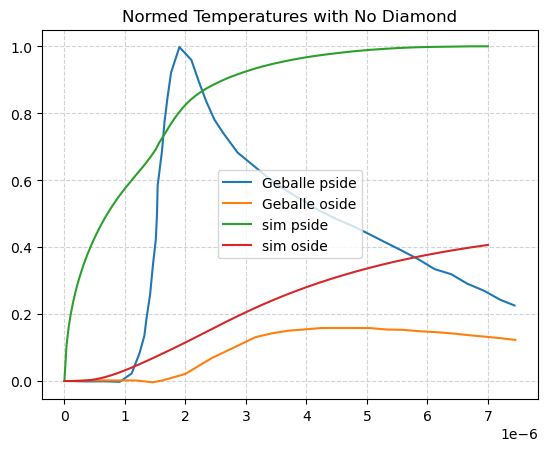

In [158]:
from io_utilities.xdmf_extract import *

time, data = extract_point_timeseries_xdmf(
    os.path.join(save_folder, 'solution.xdmf'),
    function_name='Temperature (K)',
    query_points=[(bx_ir_pside, 0), (BX_ir_oside, 0)]
)

sim_df = pd.DataFrame({'time': time,
                       'pside': data[0],
                       'oside': data[1]})

sim_df['normed pside'] = (sim_df['pside'] - sim_df['pside'].iloc[0]) / (sim_df['pside'].max() - sim_df['pside'].min())
sim_df['normed oside'] = (sim_df['oside'] - sim_df['oside'].iloc[0]) / (sim_df['pside'].max() - sim_df['pside'].min())

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title('Normed Temperatures with No Diamond')
ax.plot(df_pside['time'], df_pside['normed temperature'], label='Geballe pside')
ax.plot(df_oside['time'], df_oside['normed temperature'], label='Geballe oside')
ax.plot(sim_df['time'], sim_df['normed pside'], label='sim pside')
ax.plot(sim_df['time'], sim_df['normed oside'], label='sim oside')
ax.grid(True, ls = '--', color = 'lightgray')


ax.legend()
plt.show()


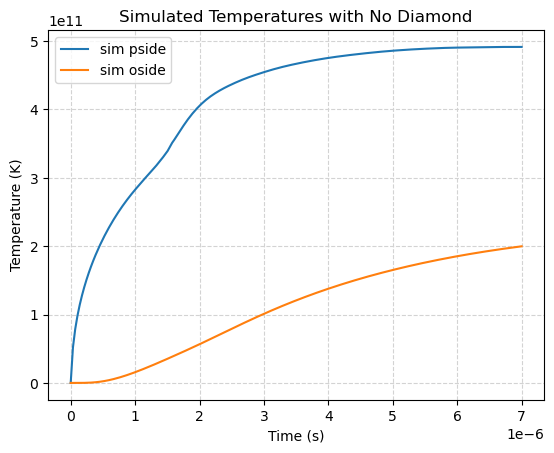

In [131]:
fig, ax = plt.subplots()
ax.plot(sim_df['time'], sim_df['pside'], label='sim pside')
ax.plot(sim_df['time'], sim_df['oside'], label='sim oside')

ax.set_title('Simulated Temperatures with No Diamond')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (K)')
ax.grid(True, ls='--', color='lightgray')
ax.legend()
plt.show()

In [24]:
max(sim_df['pside'])

2650.5637719679416

In [25]:
max(sim_df['normed oside'] - max(df_oside['normed temperature']))

0.02585628208207158

In [26]:
df_oside['temperature'].iloc[0] - df_pside['temperature'].iloc[0]

np.float64(287.88913300000013)

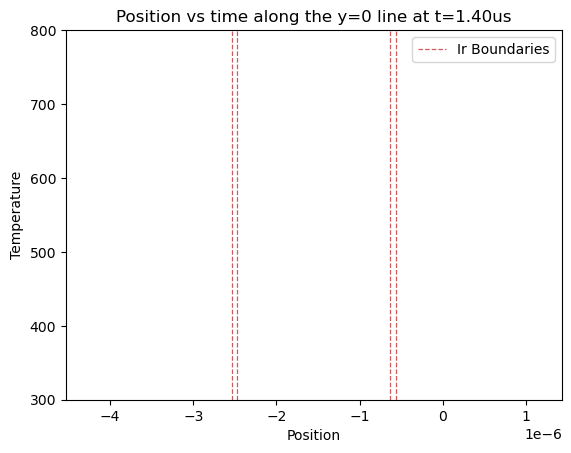

In [27]:

query_points = []
xmin = bx_ir_pside - 2e-6
xmax = BX_ir_oside + 2e-6
samples = 200

for x in np.linspace(xmin, xmax, samples):
    query_points.append((x, 0.0))

time, data = extract_point_timeseries_xdmf(
    os.path.join(save_folder, 'solution.xdmf'),
    function_name='Temperature (K)',
    query_points=query_points
)
locations = np.arange(data.shape[0])

sim_df = pd.DataFrame(data, index=locations.astype(int), columns=time)

fig, ax = plt.subplots()

t0 = 40
location_series = (locations/samples) * (xmax - xmin) + xmin
ymin = 300
ymax = 800

ax.plot(location_series, sim_df.iloc[:, t0], zorder = 3, color = 'black')
ax.vlines([BX_sample, bx_sample, bx_ir_pside, BX_ir_oside], ymin=ymin, ymax=ymax, ls='--', label='Ir Boundaries', color='indianred', zorder=2, lw=0.9)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Position')
ax.set_ylabel('Temperature')
ax.set_title(f'Position vs time along the y=0 line at t={t0*dt*1e6:.2f}us')
ax.legend()
plt.show()
